In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.calibration import LabelEncoder
import matplotlib.pyplot as plt

In [2]:
root = './CarDataset'

# Convert images into tensors
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

images, labels, class_counts, class_examples = [], [], [0, 0, 0, 0], {}
for filename in os.listdir(root):
    # Identify images that belong to one of four classes and balance data
    if filename.lower().find('ford') != -1 and class_counts[0] < 500:
        brand = 'Ford'
        class_counts[0] += 1
    elif filename.lower().find('toyota') != -1 and class_counts[1] < 500:
        brand = 'Toyota'
        class_counts[1] += 1
    elif filename.lower().find('chevrolet') != -1 and class_counts[2] < 500:
        brand = 'Chevrolet'
        class_counts[2] += 1
    elif filename.lower().find('porsche') != -1  and class_counts[3] < 500:
        brand = 'Porsche'
        class_counts[3] += 1
    else:
        continue
    
    # Sample one image from each class
    if brand not in class_examples:
        class_examples[brand] = os.path.join(root, filename)

    fp = os.path.join(root, filename)
    image = Image.open(fp).convert('RGB') 
    images.append(transform(image))
    labels.append(brand)

data = {'Images': images, 'Brand': labels}
cars = pd.DataFrame(data)

# Check that subset of data is balanced
counts = cars.groupby('Brand').count()
print(counts)

           Images
Brand            
Chevrolet     500
Ford          500
Porsche       500
Toyota        500


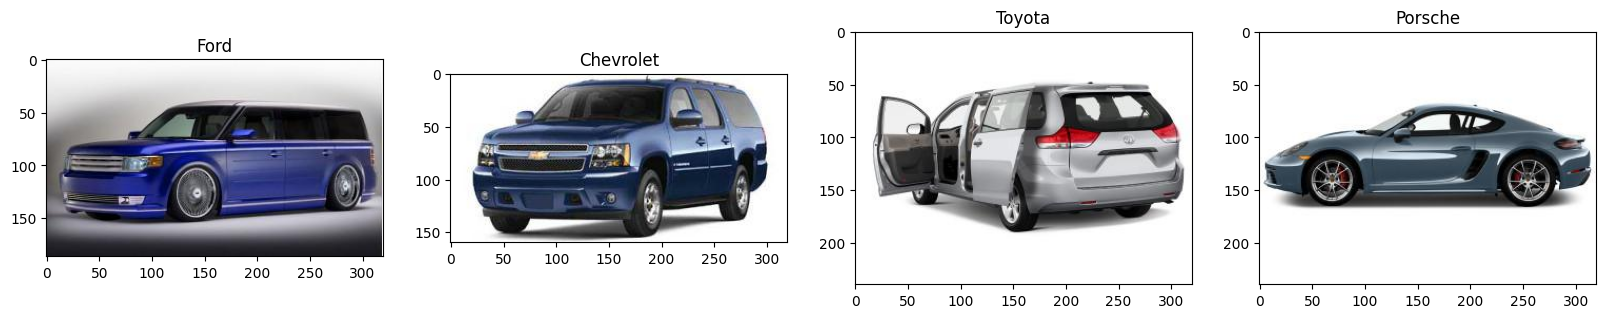

In [3]:
# Visualize images belonging to each selected class
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i, (brand, example_path) in enumerate(class_examples.items()):
    image = Image.open(example_path).convert('RGB')
    image_tensor = transform(image)
    axes[i].imshow(image)
    axes[i].set_title(brand)
plt.show()

In [4]:
# Numericalize labels and transform into tensors
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels = torch.tensor(labels_encoded)

# Split training and testing data
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [5]:
# Define neural net architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 4)  # 4 classes: Ford, Toyota, Chevrolet, BMW

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 32 * 32)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNN()

# Use optimizers and hyperparameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 1/10.. Training loss: 1.411.. Test loss: 1.384.. Test accuracy: 0.257
Epoch 2/10.. Training loss: 1.334.. Test loss: 1.348.. Test accuracy: 0.350
Epoch 3/10.. Training loss: 1.008.. Test loss: 1.663.. Test accuracy: 0.368
Epoch 4/10.. Training loss: 0.589.. Test loss: 2.367.. Test accuracy: 0.433
Epoch 5/10.. Training loss: 0.282.. Test loss: 3.302.. Test accuracy: 0.438
Epoch 6/10.. Training loss: 0.131.. Test loss: 4.813.. Test accuracy: 0.407
Epoch 7/10.. Training loss: 0.153.. Test loss: 3.742.. Test accuracy: 0.415
Epoch 8/10.. Training loss: 0.077.. Test loss: 4.767.. Test accuracy: 0.435
Epoch 9/10.. Training loss: 0.034.. Test loss: 4.932.. Test accuracy: 0.440
Epoch 10/10.. Training loss: 0.090.. Test loss: 4.787.. Test accuracy: 0.442


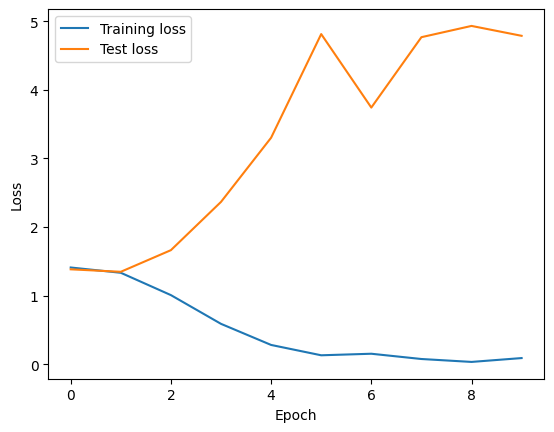

In [6]:
epochs = 10
train_losses = []
test_losses = []
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(zip(X_train, y_train)):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs.unsqueeze(0))
        loss = criterion(outputs, labels.unsqueeze(0))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(X_train))

    # Evaluate on testing set
    model.eval()
    test_loss = 0
    accuracy = 0
    with torch.no_grad():
        for inputs, labels in zip(X_test, y_test):
            outputs = model(inputs.unsqueeze(0))
            test_loss += criterion(outputs, labels.unsqueeze(0))
            ps = torch.exp(outputs)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor))
    test_losses.append(test_loss / len(X_test))

    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Training loss: {train_losses[-1]:.3f}.. "
          f"Test loss: {test_losses[-1]:.3f}.. "
          f"Test accuracy: {accuracy/len(X_test):.3f}")

# Plotting training and testing losses
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()